In [14]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from transformers import BertTokenizer, BertForQuestionAnswering, AdamW
from torchtext.datasets import SQuAD2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import random

In [16]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [30]:
# 1. Load the SQUAD 2.0 dataset
print("\nStep 1: Loading SQuAD 2.0 dataset...")
train_iter = iter(SQuAD2(split='train'))
data = []
num_samples = 100

try:
    while len(data) < num_samples:
        item = next(train_iter)
        # Check if the example has an answer
        if item[2]:  # If answer text exists
            data.append({
                'context': item[0],
                'question': item[1],
                'answer': item[2],
                'answer_start': item[3][0] if isinstance(item[3], list) and item[3] else -1  # Take first answer start position
            })
except StopIteration:
    pass

print(f"Loaded {len(data)} samples")


Step 1: Loading SQuAD 2.0 dataset...
Loaded 100 samples


In [32]:
# 2. Display raw QnA samples
print("\nStep 2: Displaying raw QnA samples...")
print("\nDisplaying 3 raw samples:")
for i in range(min(3, len(data))):
    print(f"\nSample {i+1}:")
    print(f"Context: {data[i]['context'][:200]}...")
    print(f"Question: {data[i]['question']}")
    print(f"Answer: {data[i]['answer']}")
    print(f"Answer Start Position: {data[i]['answer_start']}")
    print("-" * 80)


Step 2: Displaying raw QnA samples...

Displaying 3 raw samples:

Sample 1:
Context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in v...
Question: When did Beyonce start becoming popular?
Answer: ['in the late 1990s']
Answer Start Position: 269
--------------------------------------------------------------------------------

Sample 2:
Context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in v...
Question: What areas did Beyonce compete in when she was growing up?
Answer: ['singing and dancing']
Answer Start Position: 207
--------------------------------------------------------------------------------

Sample 3:
Context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born Sept

In [34]:
# 3. Preprocess/Clean dataset as per BERT format
print("\nStep 3: Preprocessing dataset for BERT...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 384

inputs_lst = []
masks_lst = []
start_positions_lst = []
end_positions_lst = []

for item in tqdm(data, desc="Processing"):
    # Tokenize input
    encoding = tokenizer(
        item['question'],
        item['context'],
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    
    # Calculate answer positions
    answer_start = item['answer_start']
    if isinstance(item['answer'], list):
        answer_text = item['answer'][0]  # Take first answer if multiple exist
    else:
        answer_text = item['answer']
        
    if answer_text and answer_start >= 0:
        context_before_answer = item['context'][:answer_start]
        answer_tokens = len(tokenizer.encode(answer_text, add_special_tokens=False))
        question_tokens = len(tokenizer.encode(item['question'], add_special_tokens=True))
        context_before_tokens = len(tokenizer.encode(context_before_answer, add_special_tokens=False))
        
        start_pos = question_tokens + context_before_tokens
        end_pos = start_pos + answer_tokens - 1
    else:
        start_pos = 0
        end_pos = 0
    
    inputs_lst.append(encoding['input_ids'].flatten())
    masks_lst.append(encoding['attention_mask'].flatten())
    start_positions_lst.append(start_pos)
    end_positions_lst.append(end_pos)

# Create PyTorch tensors
inputs = torch.stack(inputs_lst)
masks = torch.stack(masks_lst)
start_positions = torch.tensor(start_positions_lst)
end_positions = torch.tensor(end_positions_lst)

# Split into train and validation sets
train_size = int(0.8 * len(inputs))
val_size = len(inputs) - train_size

indices = torch.randperm(len(inputs))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Create train and validation tensors
train_data = [
    {
        'input_ids': inputs[i].to(device),
        'attention_mask': masks[i].to(device),
        'start_positions': start_positions[i].to(device),
        'end_positions': end_positions[i].to(device),
        'context': data[i]['context'],
        'question': data[i]['question'],
        'answer': data[i]['answer'] if not isinstance(data[i]['answer'], list) else data[i]['answer'][0]
    }
    for i in train_indices
]

val_data = [
    {
        'input_ids': inputs[i].to(device),
        'attention_mask': masks[i].to(device),
        'start_positions': start_positions[i].to(device),
        'end_positions': end_positions[i].to(device),
        'context': data[i]['context'],
        'question': data[i]['question'],
        'answer': data[i]['answer'] if not isinstance(data[i]['answer'], list) else data[i]['answer'][0]
    }
    for i in val_indices
]

batch_size = 4
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)



Step 3: Preprocessing dataset for BERT...


Processing: 100%|██████████| 100/100 [00:00<00:00, 189.27it/s]



Step 4: Training and evaluating BERT QnA model...


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monicalokare/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Validating: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 1/15:
Average Training Loss: 5.5775
Average Validation Loss: 5.0037



Validating: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


Epoch 2/15:
Average Training Loss: 4.3079
Average Validation Loss: 4.3751



Validating: 100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


Epoch 3/15:
Average Training Loss: 3.4095
Average Validation Loss: 4.4718



Validating: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Epoch 4/15:
Average Training Loss: 2.8023
Average Validation Loss: 4.6332



Validating: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


Epoch 5/15:
Average Training Loss: 2.5533
Average Validation Loss: 4.9189



Validating: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 6/15:
Average Training Loss: 2.3507
Average Validation Loss: 5.8431



Validating: 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


Epoch 7/15:
Average Training Loss: 2.1927
Average Validation Loss: 4.7895



Validating: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


Epoch 8/15:
Average Training Loss: 2.2374
Average Validation Loss: 5.7316



Validating: 100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


Epoch 9/15:
Average Training Loss: 1.9087
Average Validation Loss: 5.7360



Validating: 100%|██████████| 5/5 [00:11<00:00,  2.25s/it]


Epoch 10/15:
Average Training Loss: 1.7524
Average Validation Loss: 6.0781



Validating: 100%|██████████| 5/5 [00:12<00:00,  2.47s/it]


Epoch 11/15:
Average Training Loss: 1.4281
Average Validation Loss: 5.7929



Validating: 100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


Epoch 12/15:
Average Training Loss: 1.2214
Average Validation Loss: 5.9420



Validating: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 13/15:
Average Training Loss: 1.0219
Average Validation Loss: 5.7612



Validating: 100%|██████████| 5/5 [00:10<00:00,  2.07s/it]


Epoch 14/15:
Average Training Loss: 0.7539
Average Validation Loss: 5.7761



Validating: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 15/15:
Average Training Loss: 0.4677
Average Validation Loss: 6.8338



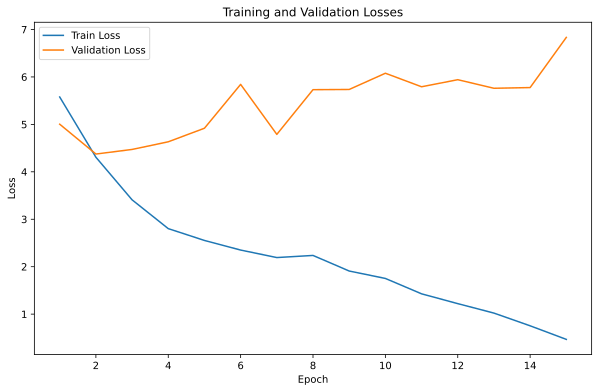

In [36]:
# 4. Train the BERT QnA model and evaluate
print("\nStep 4: Training and evaluating BERT QnA model...")
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

max_epochs = 15
train_losses = []
val_losses = []

for epoch in range(max_epochs):
    # Training
    model.train()
    epoch_train_loss = 0
    train_steps = 0
    
    for batch in tqdm(train_loader, desc=f'Training Epoch {epoch + 1}'):
        optimizer.zero_grad()
        
        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            start_positions=batch['start_positions'],
            end_positions=batch['end_positions']
        )
        
        loss = outputs.loss
        epoch_train_loss += loss.item()
        train_steps += 1
        
        loss.backward()
        optimizer.step()
    
    avg_train_loss = epoch_train_loss / train_steps
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    epoch_val_loss = 0
    val_steps = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating'):
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                start_positions=batch['start_positions'],
                end_positions=batch['end_positions']
            )
            
            loss = outputs.loss
            epoch_val_loss += loss.item()
            val_steps += 1
    
    avg_val_loss = epoch_val_loss / val_steps
    val_losses.append(avg_val_loss)
    
    print(f'Epoch {epoch + 1}/{max_epochs}:')
    print(f'Average Training Loss: {avg_train_loss:.4f}')
    print(f'Average Validation Loss: {avg_val_loss:.4f}\n')

# Plot training results
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, max_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [42]:
# 5. Perform Inference and compare with ground truth
print("\nStep 5: Performing inference and comparing with ground truth...")
print("\nEvaluating on validation samples:")
model.eval()

# Improved answer extraction function
def get_answer(model, tokenizer, question, context):
    inputs = tokenizer(
        question,
        context,
        return_tensors="pt",
        max_length=max_len,
        truncation=True,
        padding='max_length'
    )
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        # Get the most probable start and end positions
        start_scores = outputs.start_logits
        end_scores = outputs.end_logits
        
        # Get the most probable answer span
        max_answer_length = 30  # Maximum length of answer in tokens
        start_idx = torch.argmax(start_scores)
        end_idx = torch.argmax(end_scores)
        
        # Ensure end comes after start and answer isn't too long
        if end_idx < start_idx:
            end_idx = start_idx + 3
        if end_idx - start_idx + 1 > max_answer_length:
            end_idx = start_idx + max_answer_length - 1
            
        answer_tokens = inputs["input_ids"][0][start_idx:end_idx + 1]
        answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)
        
        # Clean up the answer
        answer = answer.strip()
        if not answer:
            answer = "Unable to find answer"
            
        return answer

print("\nPredictions vs Ground Truth:")
for i in range(min(5, len(val_data))):
    sample = val_data[i]
    predicted_answer = get_answer(model, tokenizer, sample['question'], sample['context'])
    
    print(f"\nExample {i+1}:")
    print(f"Question: {sample['question']}")
    print(f"Context: {sample['context'][:200]}...")
    print(f"Ground Truth: {sample['answer']}")
    print(f"Predicted: {predicted_answer}")
    print("-" * 80)


Step 5: Performing inference and comparing with ground truth...

Evaluating on validation samples:

Predictions vs Ground Truth:

Example 1:
Question: Where did Destiny's Child get their name from?
Context: The group changed their name to Destiny's Child in 1996, based upon a passage in the Book of Isaiah. In 1997, Destiny's Child released their major label debut song "Killing Time" on the soundtrack to ...
Ground Truth: Book of Isaiah.
Predicted: no, no,
--------------------------------------------------------------------------------

Example 2:
Question: For what movie did Beyonce receive  her first Golden Globe nomination?
Context: Following the disbandment of Destiny's Child in June 2005, she released her second solo album, B'Day (2006), which contained hits "Déjà Vu", "Irreplaceable", and "Beautiful Liar". Beyoncé also venture...
Ground Truth: Dreamgirls
Predicted: dreamgirls
--------------------------------------------------------------------------------

Example 3:
Question: Wh

In [47]:
# Evaluate model performance
print("\nModel Evaluation:")
model.eval()
total_exact_match = 0
total_f1 = 0
n_samples = 0

def compute_exact_match(prediction, ground_truth):
    return int(prediction.strip().lower() == ground_truth.strip().lower())

def compute_f1(prediction, ground_truth):
    pred_tokens = prediction.lower().split()
    truth_tokens = ground_truth.lower().split()
    
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    if not common_tokens:
        return 0
    
    precision = len(common_tokens) / len(pred_tokens)
    recall = len(common_tokens) / len(truth_tokens)
    
    if precision + recall == 0:
        return 0
        
    f1 = 2 * precision * recall / (precision + recall)
    return f1

with torch.no_grad():
    for batch in val_loader:
        predictions = []
        ground_truths = []
        
        # Get predictions
        for question, context in zip(batch['question'], batch['context']):
            pred = get_answer(model, tokenizer, question, context)
            predictions.append(pred)
            
        # Get ground truths
        ground_truths = [ans if not isinstance(ans, list) else ans[0] for ans in batch['answer']]
        
        # Compute metrics
        for pred, truth in zip(predictions, ground_truths):
            total_exact_match += compute_exact_match(pred, truth)
            total_f1 += compute_f1(pred, truth)
            n_samples += 1

# Calculate final metrics
exact_match = (total_exact_match / n_samples) * 100
f1_score = (total_f1 / n_samples) * 100

print(f"\nEvaluation Metrics:")
print(f"Exact Match: {exact_match:.2f}%")
print(f"F1 Score: {f1_score:.2f}%")



Model Evaluation:

Evaluation Metrics:
Exact Match: 15.00%
F1 Score: 16.07%


### Training and Validation Loss:Training Loss steadily decreased from 5.57 to 0.47 over 15 epochs, indicating that the model learned the training data well.
Validation Loss fluctuated, dropping initially but increasing in later epochs, peaking at 6.83. This suggests overfitting. To address this:
Use techniques like early stopping, regularization, or dropout.
Consider using more data or employing data augmentation.
#### Inference:Predictions were reasonable in some cases (e.g., "Dreamgirls" predicted correctly).
However, some predictions were clearly incorrect (e.g., "no, no," for the first example).
This indicates that the model struggles with fine-grained answer extraction or ambiguous contexts.
#### Exact Match (EM): 15%
This measures how often the model's predictions exactly match the ground truth.
A low score suggests the model is not extracting the exact answer consistently.
#### F1 Score: 16.07%
This combines precision and recall, reflecting partial overlap between predicted and true answers.
A low score like this often results from predictions that are partially correct (e.g., incorrect phrasing, missing details).

### The assignment demonstrates a solid understanding of the BERT-based QnA pipeline but highlights areas for further refinement, especially regarding overfitting and dataset size. Addressing these issues will likely improve both Exact Match and F1 Score metrics.